<a href="https://colab.research.google.com/github/Gordon256/StaMPS/blob/master/Bias_Correction_GEOGloWS_ECMWF_Streamflow_Prediction_Services_Nile_Basin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bias Correction - GEOGloWS ECMWF Streamflow Services - Nile Basin**


GEOGloWS ECMWF Streamflow Services (GESS) solve some of the challenges for the global hydrological models to be useful in the local scale described by Souffront et al. (2019). These challenges include:

1.   **Big data management**, having a solid cyberinfrastructure where the model can be computed, stored, and retrieved automatically.
2.   **Communication**, using web applications, web services, and standards for producing, and sharing hydrological data.
3.   **Adoption** in different places in the world through the use of the Hydrologic Modeling as a Service (HMaaS), web applications and REST API's.
4.   **Validation**. Unfortunately, the calibration and validation for the model GESS have not been completely developed mainly due to the challenge of collecting and processing the necessary local data.



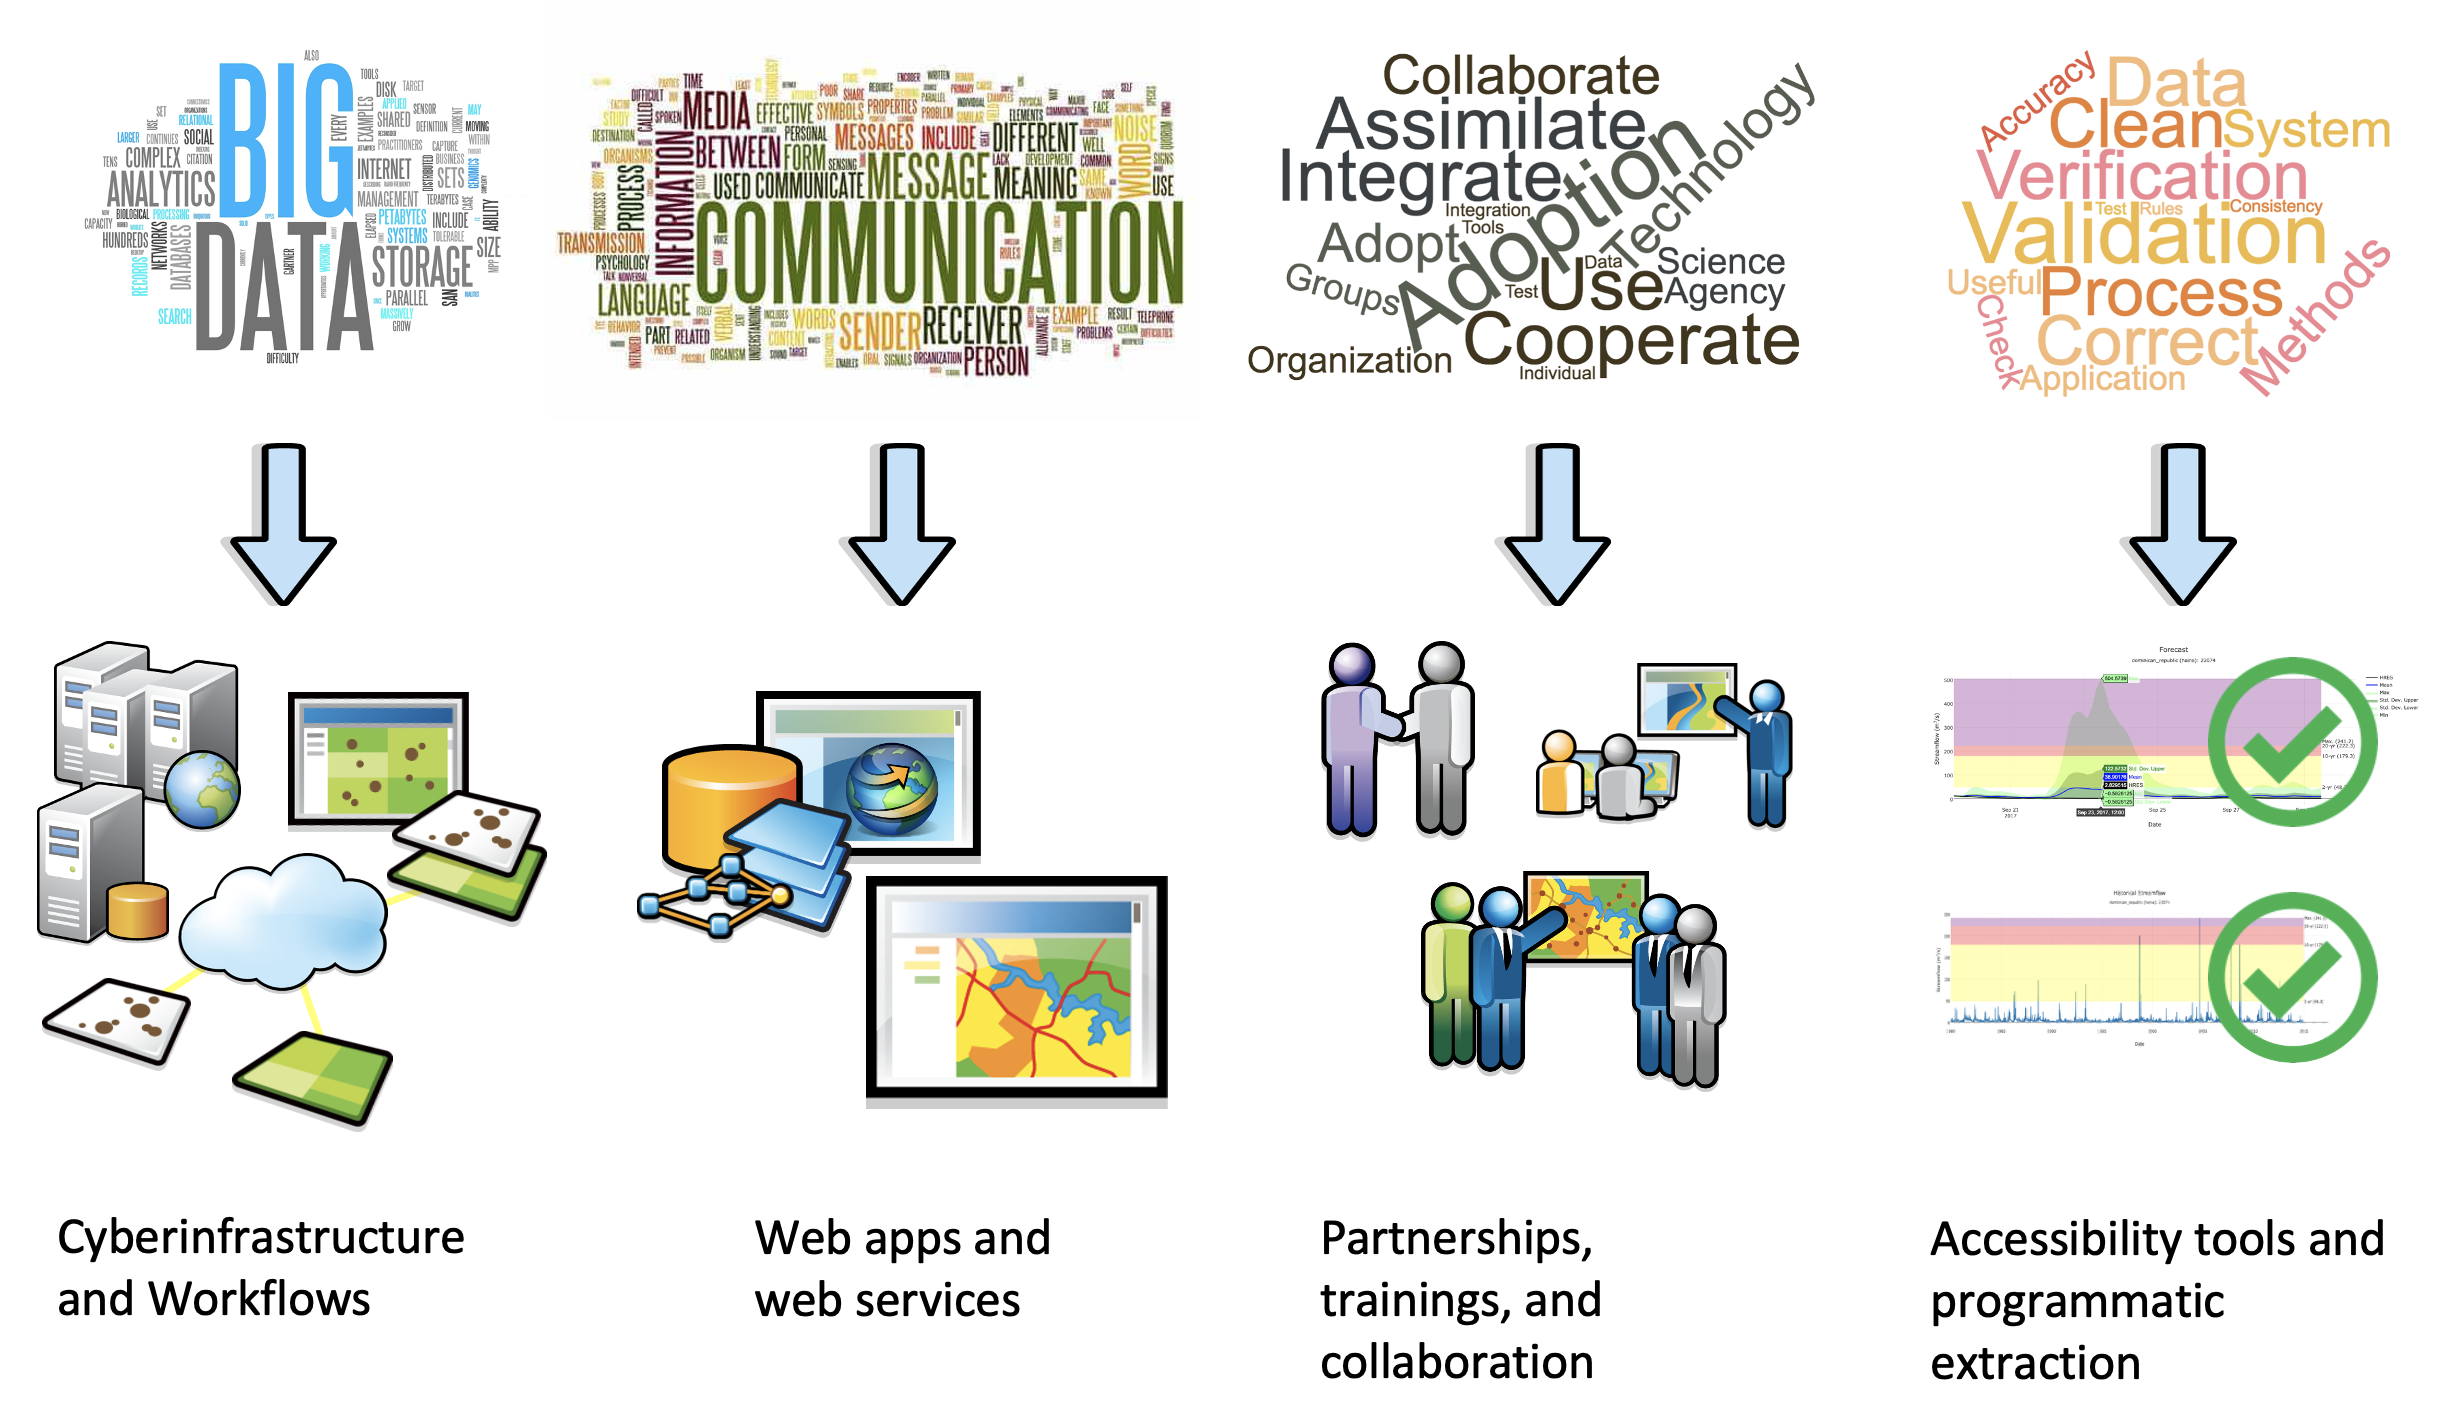

Decision makers are legitimately concerned about the accuracy and uncertainty of hydrological model predictions. The results, as with any model, do not need to be perfect, but they must be reliable and accurate enough that decision makers are confident to use them.

Developers typically assess model accuracy by comparing simulation results with observed data in local areas where they have both data and experience, areas where they have knowledge of hydrologic behaviors specific to that area.

In general, developed countries have better hydroinformatics infrastructure for data management that facilitate access to relevant hydrological observations. In contrast, in developing countries, there is less access to hydrological data, making calibration difficult. The policy and culture of sharing additional data often prohibit the kind of access and distribution necessary for widespread calibration efforts.

A bias correction methodology based on Farmer et al. (2018) aims to improve the results of GESS at the local level.

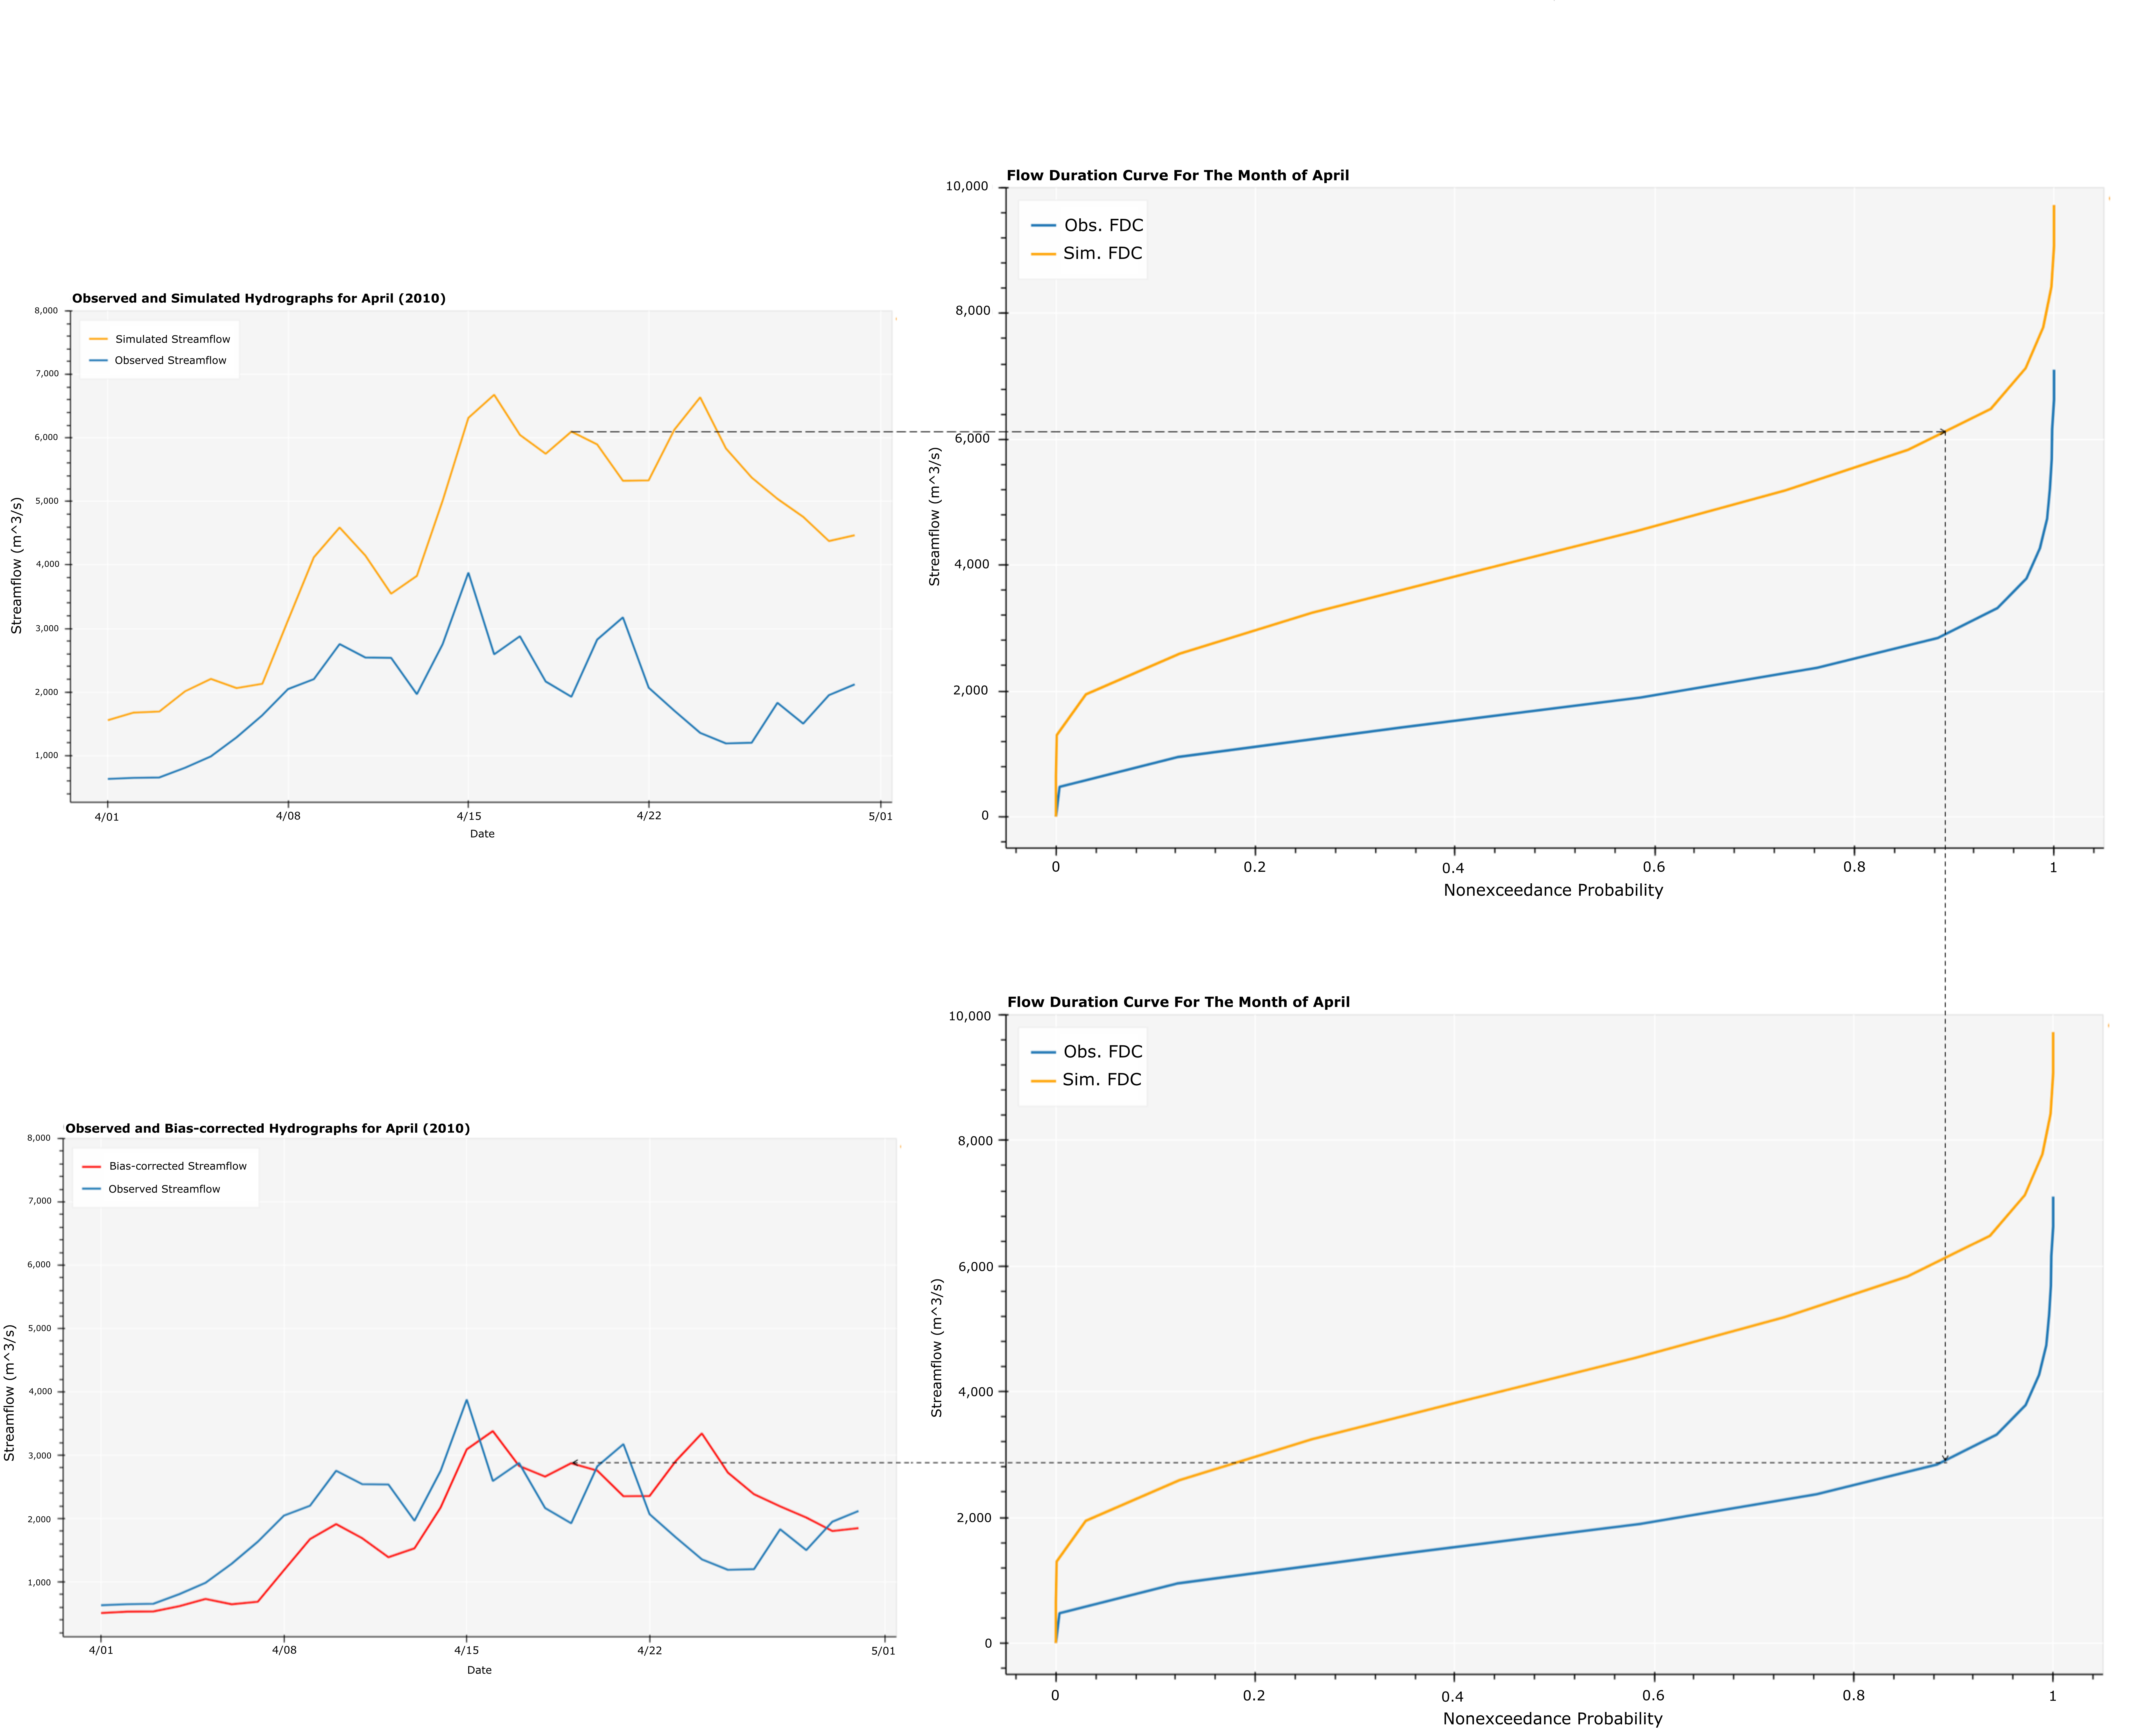

For each month in the simulated historical and observed historical time series, we compute the flow duration curve. After that, in a single month, we can estimate the non-exceedance probability of each simulated value. Therefore, we can estimate the value of the observed discharge that corresponds to that probability of non-exceedance. Finally, we convert the simulated value by replacing it with the observed flow equivalent to the same non-exceedance probability.

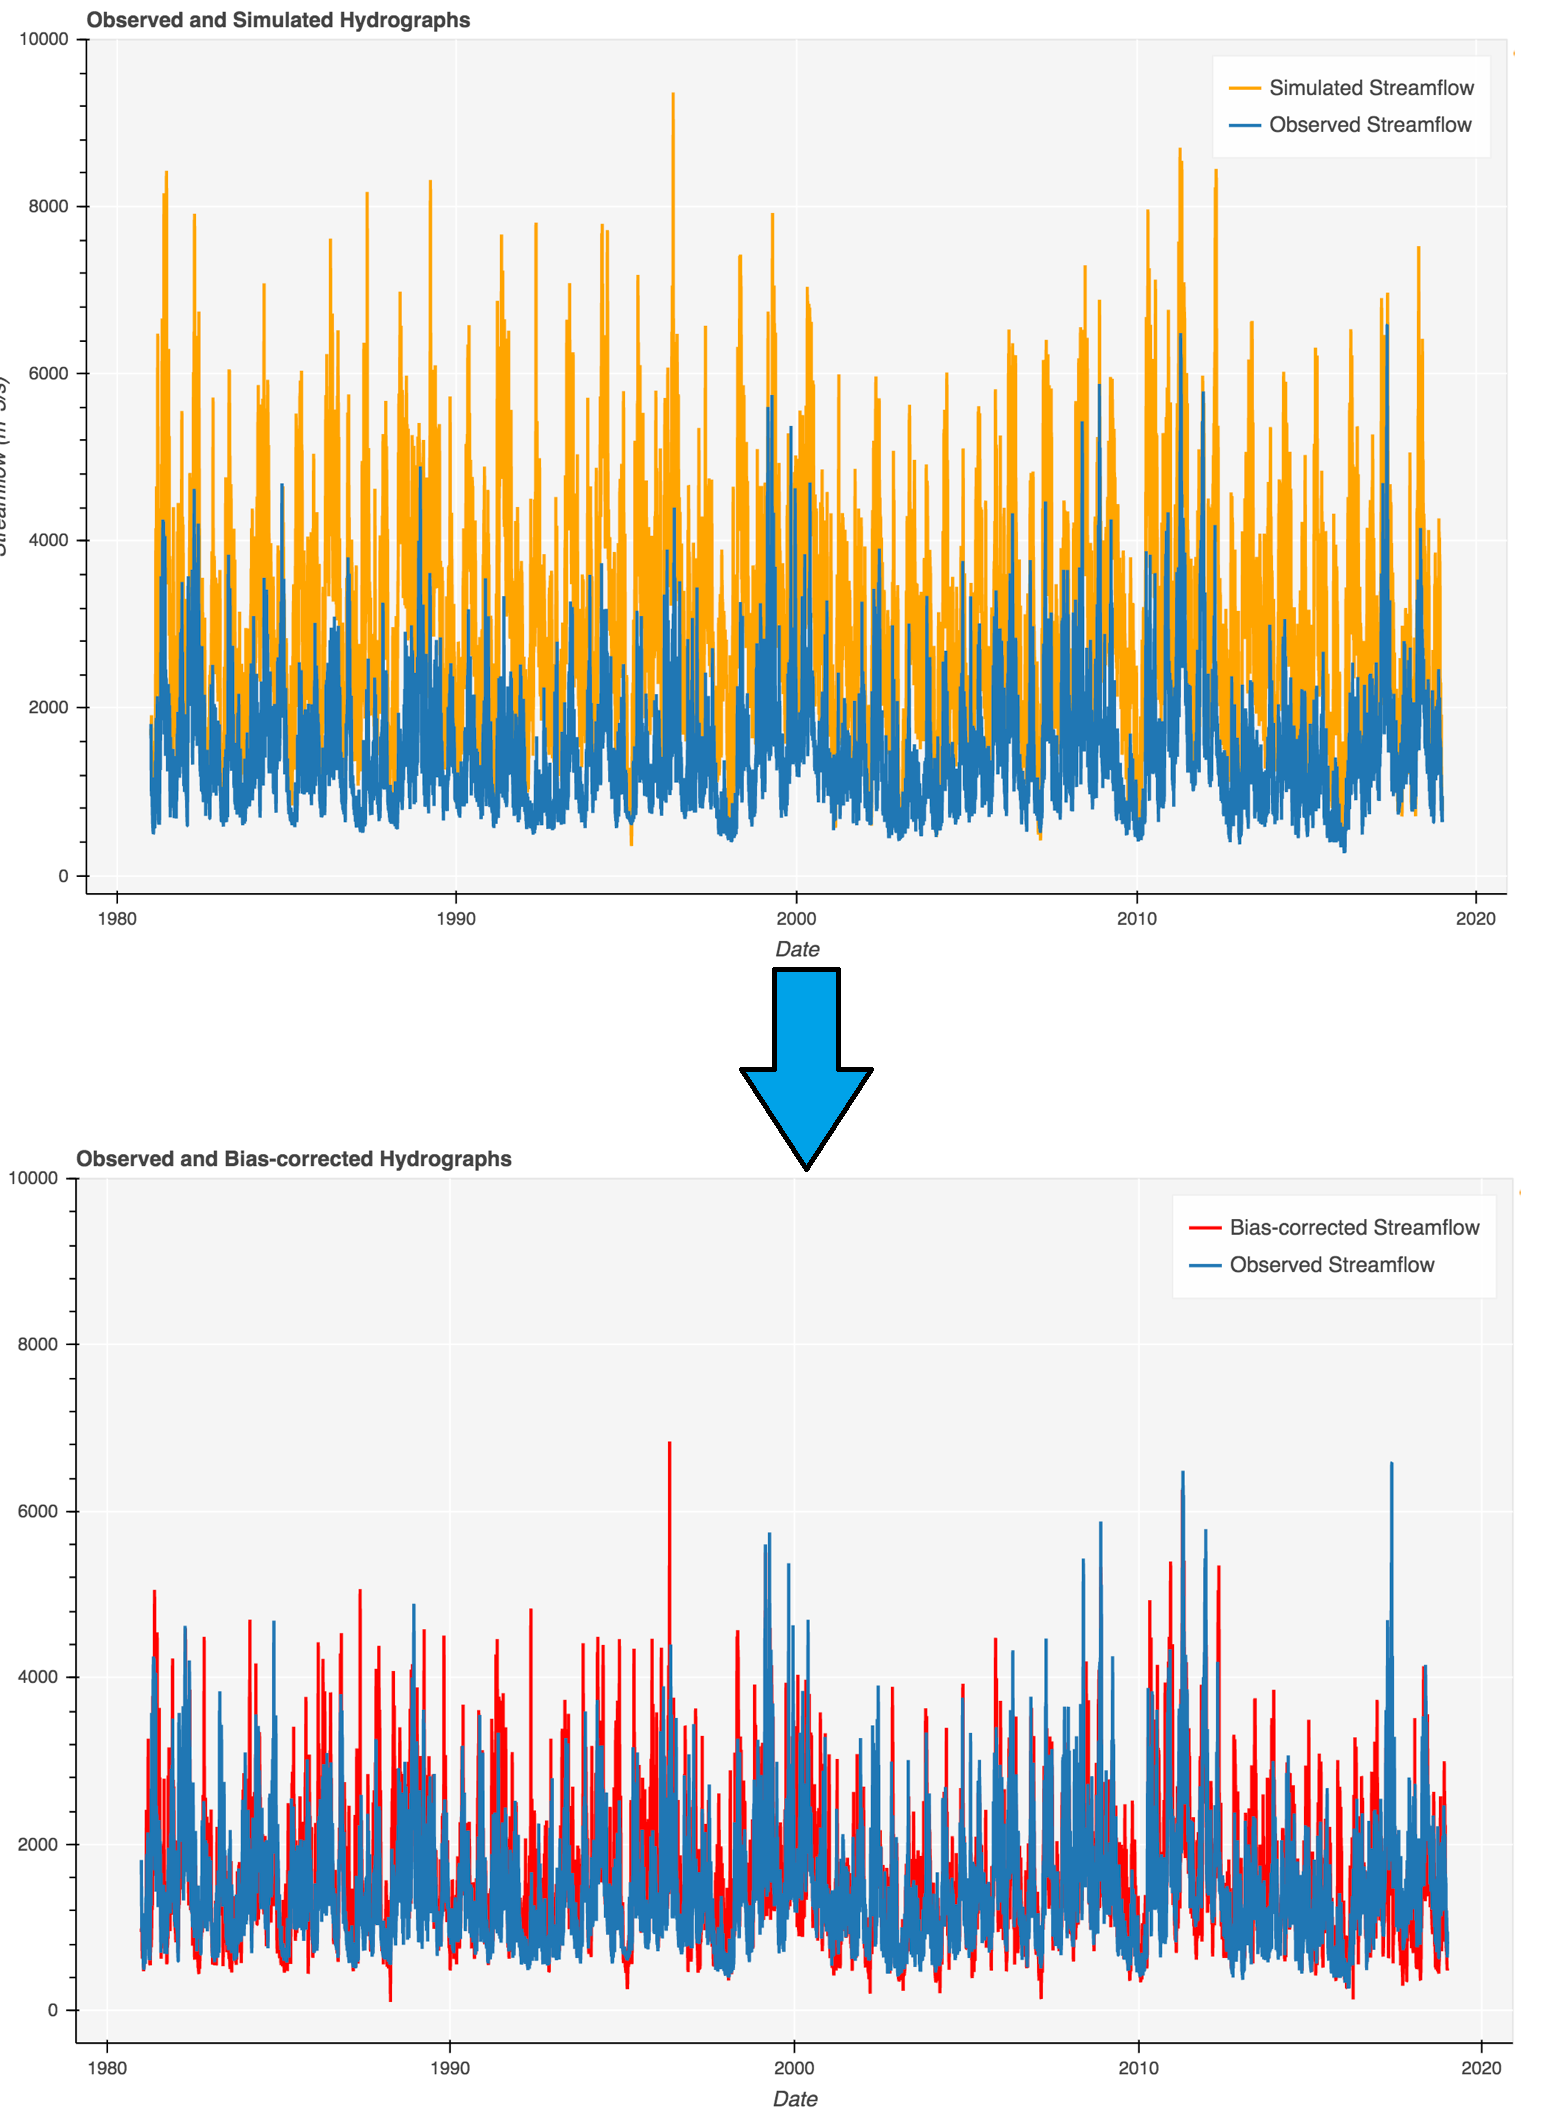

The figure above shows the bias correction applied for the entire historical simulation. After bias correction, historical simulation corrects the magnitude of the values by bringing them closer to the observed data. However, it does not correct for the timing of the spikes. However, the corrected values are in the same order of magnitude as the observed values.

We apply the methodology described above for the different gauging stations in United States. We use the Kling-Gupta coefficient of efficiency (KGE -2012) to quantify the improvement of the historical simulation. The figure below shows the results before and after bias correction.

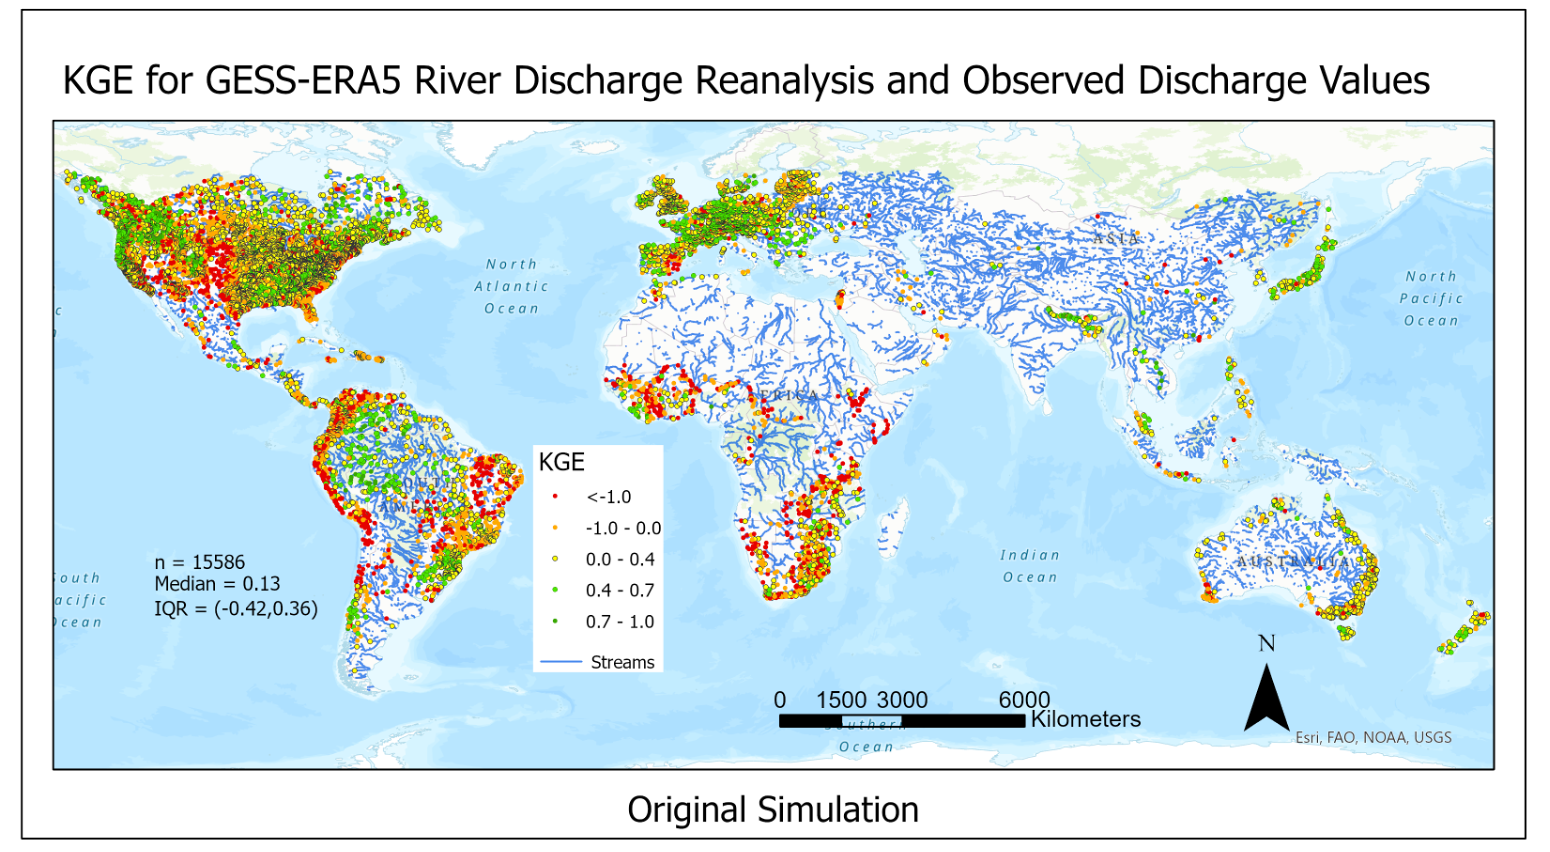

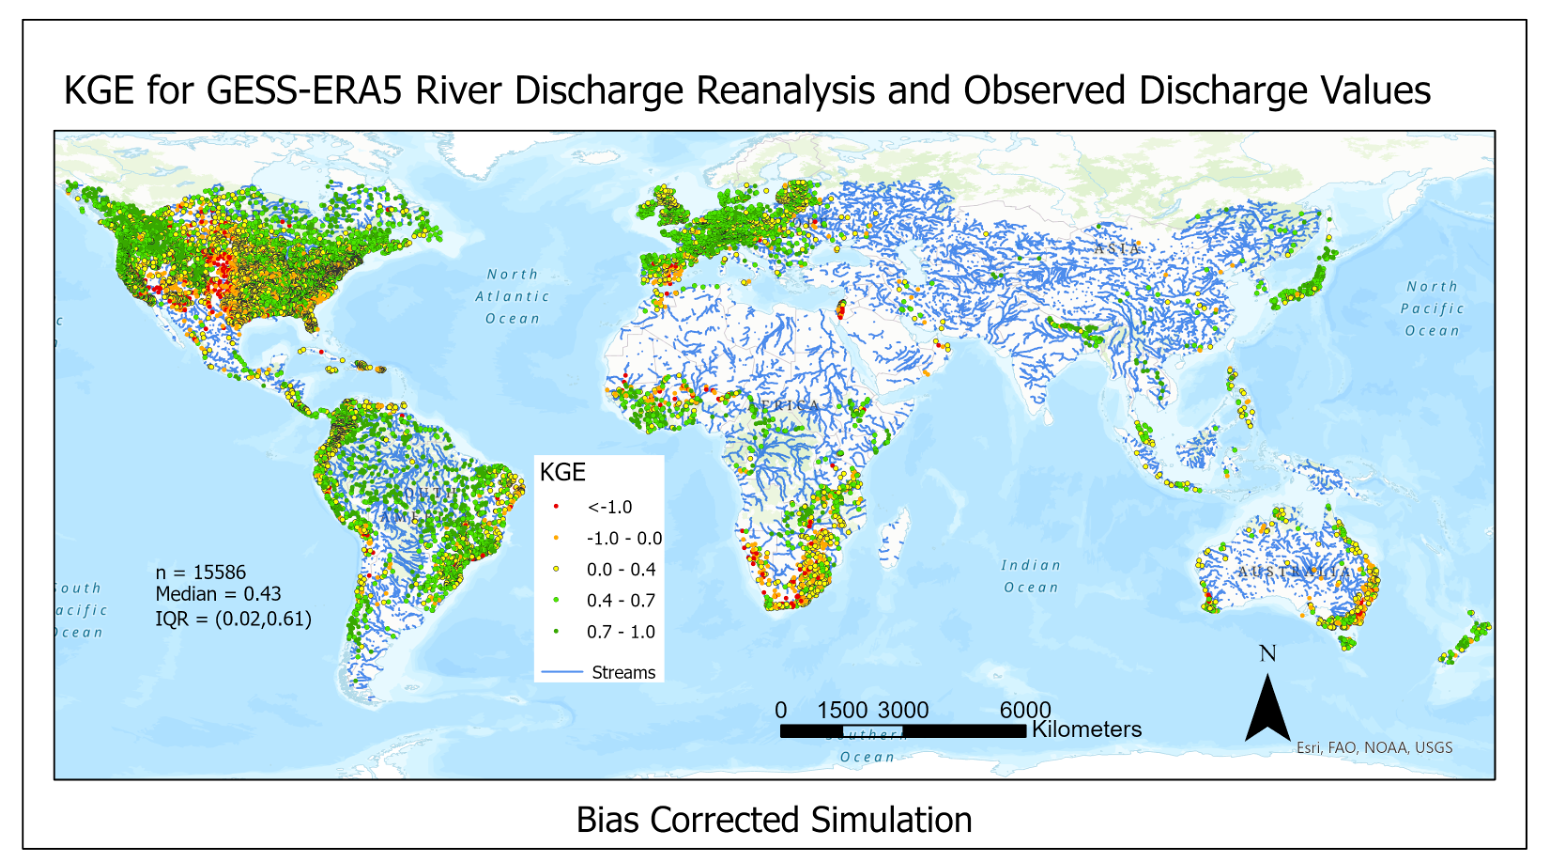

We can see an improvement in the bias-corrected historical simulation as documented by the KGE-2012 metric. These results are encouraging and suggest that this implemented bias correction can be used to locally improve forecasts where historical observations are available. We use the corrected historical simulation to define the new return periods that will define the alert threshold. The proposed methodology to correct the forecast uses the monthly flow duration curves for the simulated historical and observed flow and adjusts the forecast values in the same way as we did for the historical simulation. The Figure below describes the methodology applied to correct the short-term forecast bias of GESS.

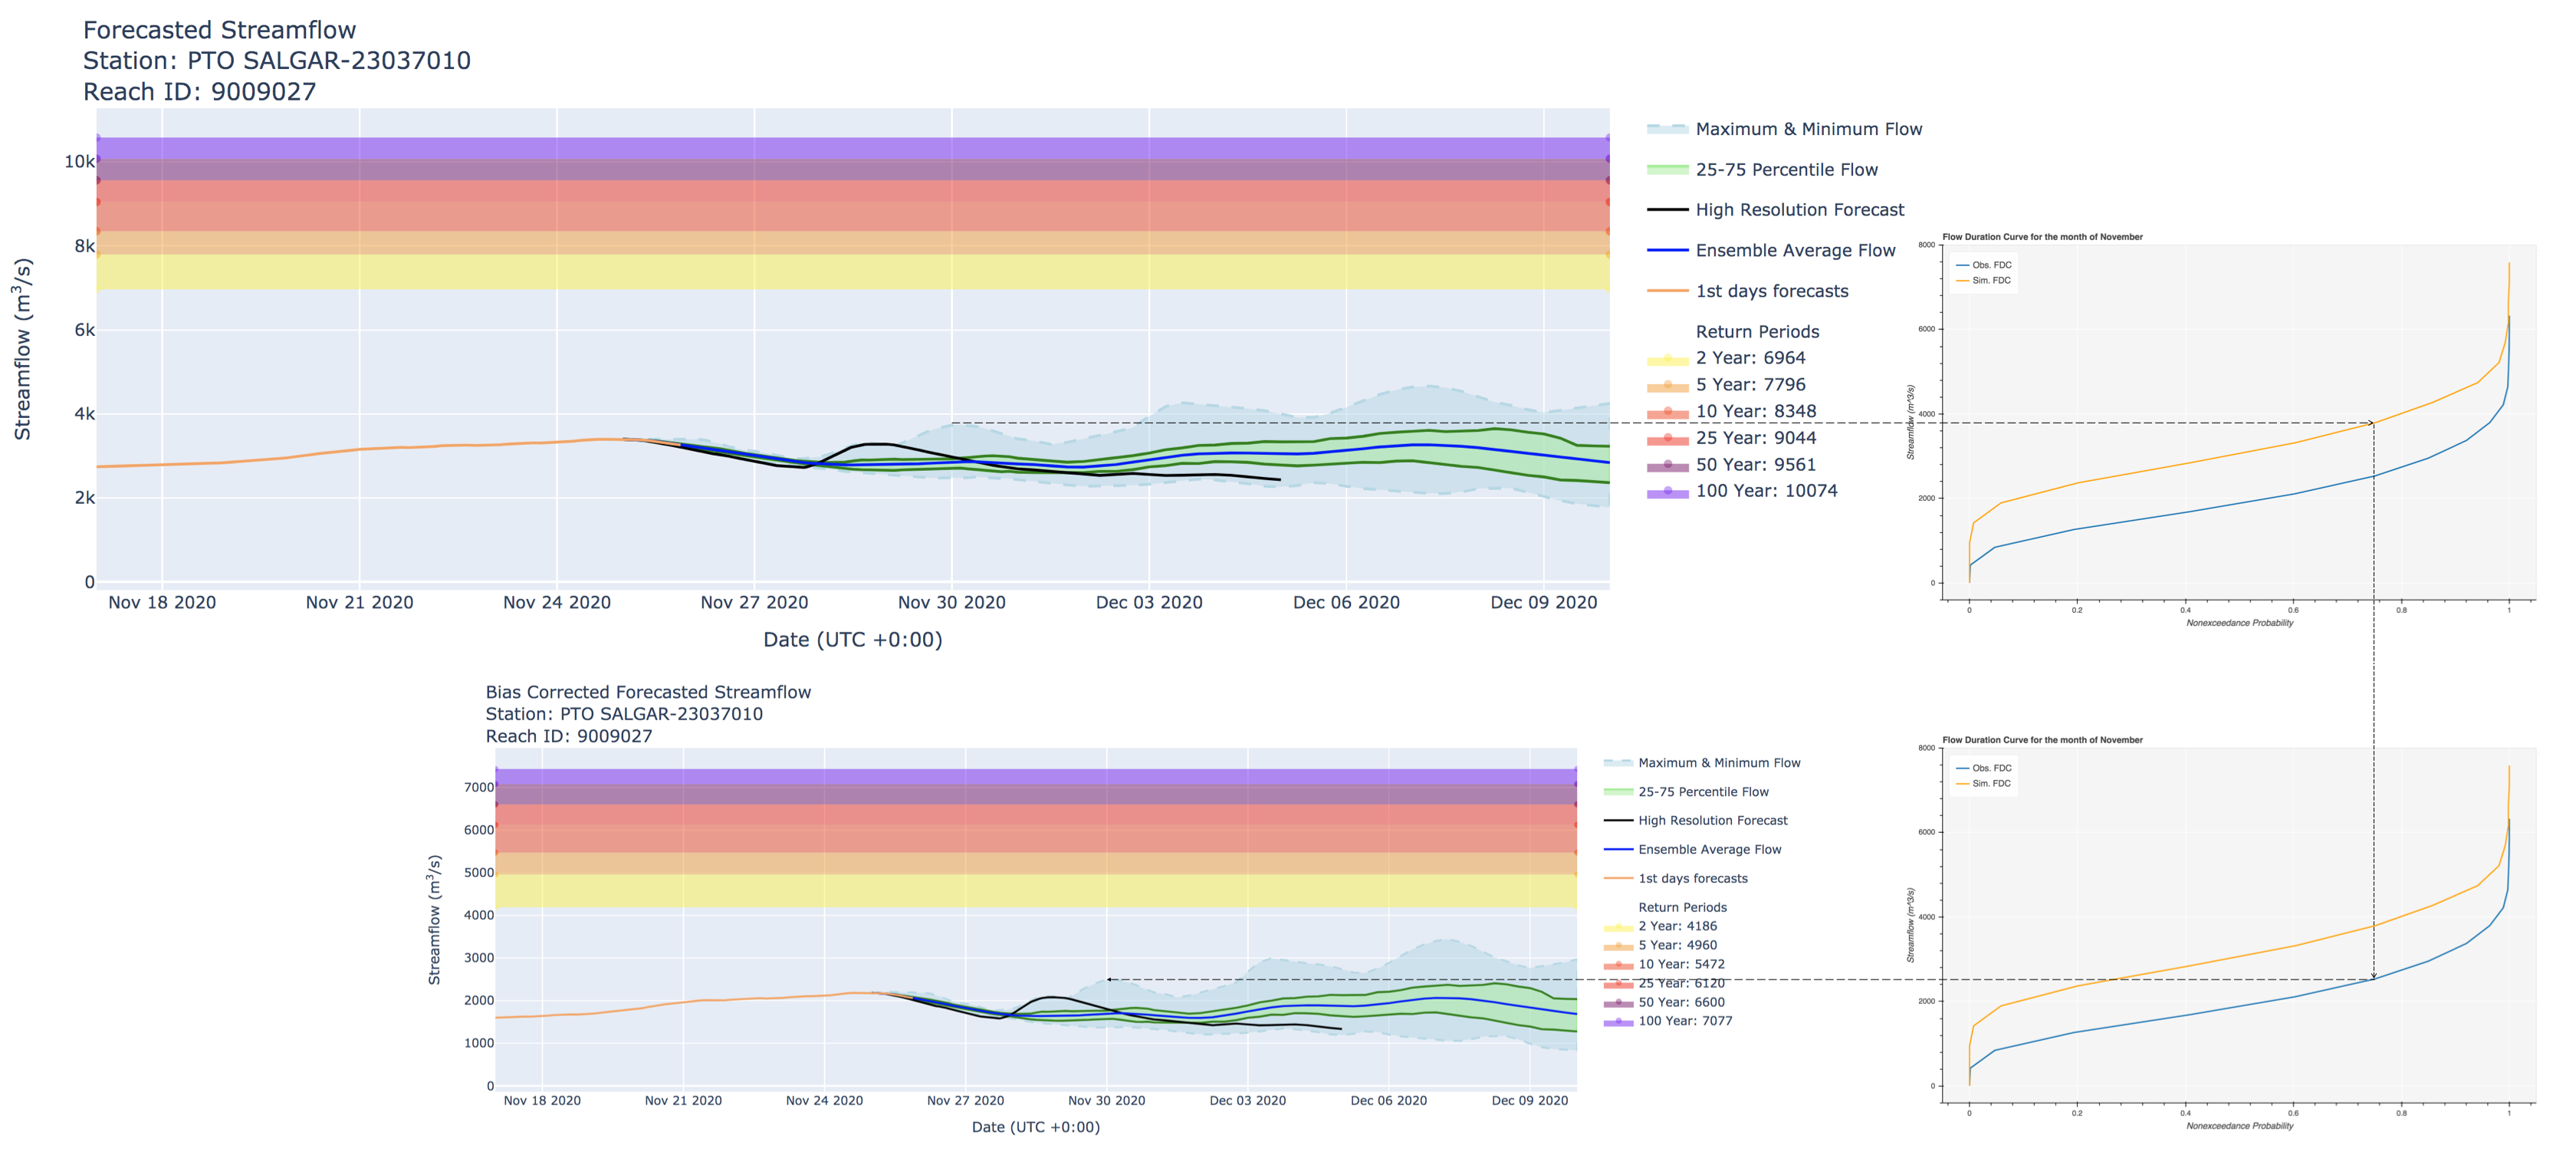

## **Python Packages to be Used**

In the development of this tutorial, the following libraries will be used:

1.   geoglows
2.   pandas
3.   plotly
4.   datetime
5.   numpy
6.   math
7.   hydrostats
8.   scipy
9.   requests

In [ ]:
!pip install geoglows

In [ ]:
import math
import requests
import geoglows
import numpy as np
import pandas as pd
import datetime as dt
import geopandas as gpd
import hydrostats as hs
import scipy.stats as sp
import plotly.express as px
import hydrostats.data as hd
import plotly.graph_objs as go
from google.colab import files
from IPython.core.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

## **Localization**

In this tutorial, we will use the following station:

river_id = 160266239

Kanzenze (Code = 4326), Nyabarongo River, Rwanda.

Latitude = -2.0613

Longitude = 30.087

In [ ]:
lat = -2.0613
lon = 30.087
river_id = 160266239
station_name = 'Kanzenze [4326]'

df = pd.DataFrame({
    'Longitude' : [lon],
    'Latitude'  : [lat],
    'Name' : station_name,
    'RIVER_ID' : str(river_id)
})

geo_df = gpd.GeoDataFrame(
    data=df,
    geometry=gpd.points_from_xy(df.Longitude, df.Latitude)
).set_crs('epsg:4326')

fig = px.scatter_mapbox(
    geo_df,
    lat=geo_df.geometry.y,
    lon=geo_df.geometry.x,
    hover_name='Name',
    hover_data=['RIVER_ID'],
    color_discrete_sequence=["red"],
    zoom=5,
    height=500
)

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "ESRI",
            "source": [
                "https://services.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"]
        },
        {
            "below": 'traces',
            "sourcetype": "raster",
            "sourceattribution": "ESRI",
            "source": [
                "https://services.arcgisonline.com/ArcGIS/rest/services/Reference/World_Boundaries_and_Places/MapServer/tile/{z}/{y}/{x}"
            ]
        },
    ]
)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# **Step 1: Obtain CSV with historical flow values**

The observed value should be in csv format with two columns. The first column should have the name 'datetime' and it should include the dates in standard format. The second column can have any name; however, the it must have the streamflow values in cubic meters per second (m<sup>3</sup>/s).

The observed data to be used is available at: https://www.hydroshare.org/resource/7ce72b91680c47599a5263ef9e00ccf5/data/contents/4326.csv

When you run the next cell, you will have the option to choose the file from your computer to upload.

In [ ]:
uploaded = files.upload()
for fn in uploaded.keys():
  uploaded_file_name = fn
  print(f'User uploaded file "{fn}"')

In [ ]:
observed_historical = pd.read_csv(uploaded_file_name, index_col=0)
observed_historical[observed_historical < 0] = 0
observed_historical.index = pd.to_datetime(observed_historical.index)
observed_historical.index = observed_historical.index.to_series().dt.strftime("%Y-%m-%d")
observed_historical.index = pd.to_datetime(observed_historical.index)

display(HTML(observed_historical.to_html()))

# **Step 2: Obtain the Historical Simulation for Bias Correction**

To obtain the historical simulation for any river reach, the corresponding `river_id` is required.

The `geoglows.bias.correct_historical` function is designed to correct biases in a historically simulated streamflow time series using observed streamflow data. This process enhances the accuracy of simulation results, especially when comparing historical and observational data.

- **Parameters**:
  - `simulated_data` (pandas.core.frame.DataFrame): A DataFrame containing simulated streamflow data with a datetime index and a single column of streamflow values.
  - `observed_data` (pandas.core.frame.DataFrame): A DataFrame containing observed streamflow data with a datetime index and a single column of streamflow values.
- **Returns**:
  - `pd.DataFrame`: The corrected DataFrame with a datetime index and a single column of adjusted streamflow values.

Example of usage:
```python
historical_data = geoglows.data.retrospective(river_id=160266239)
```

In our case, we already know the river ID of the stream we are working with. For the hydrological station on the Nyabarongo River called Kanzenze, the corresponding `river_id` is 160266239.

In [ ]:
#Edit this cell with the river ID of your stream
river_id = 160266239

In [ ]:
simulated_historical = geoglows.data.retrospective(river_id)
simulated_historical.index = pd.to_datetime(simulated_historical.index)
simulated_historical[simulated_historical < 0] = 0
simulated_historical.index = simulated_historical.index.to_series().dt.strftime("%Y-%m-%d")
simulated_historical.index = pd.to_datetime(simulated_historical.index)

display(HTML(simulated_historical.to_html()))

# **Step 3: Obtain Forecast Values and Forecast Log for Bias Correction**

## **Obtain Forecast Ensembles**

To obtain the forecast simulation for any river segment, you need the corresponding `river_id`.

The function `geoglows.data.forecast_ensembles` retrieves the forecast ensembles simulation of streamflow for a given `river_id`. Here’s how to use it:

- **Arguments**:
  - `river_id` (int): the ID of a stream, should be a 9-digit integer.
  - `format` (str): the format to return the data, either 'df' for DataFrame or 'xarray'. This argument is optional and defaults to 'df'.
  - `date` (str, optional): Specifies the date for which to retrieve forecast data in YYYYMMDD format. If not specified, the latest available data will be returned.
  - `data_source` (str, optional): Specifies the source of the data. Options are 'rest' (GEOGLOWS Rest API) or 'aws' (AWS Open Data Program GEOGLOWS V2 S3 bucket). The default is 'aws'.

- **Returns**:
  - `pd.DataFrame` or `dict` or `str`: This contains the streamflow data.

Example of Usage:
```python
forecast_data = geoglows.data.forecast_ensembles(river_id=160266239)
```

In [ ]:
ensembles = geoglows.data.forecast_ensembles(river_id)
ensembles.index = pd.to_datetime(ensembles.index)
ensembles[ensembles < 0] = 0
ensembles.index = ensembles.index.to_series().dt.strftime("%Y-%m-%d %H:%M:%S")
ensembles.index = pd.to_datetime(ensembles.index)

display(HTML(ensembles.to_html()))

## **Return Periods**

The function `geoglows.data.return_periods` retrieves the return period thresholds based on a specified historic simulation forcing for a certain `river_id`.

- **Arguments**:
  - `river_id` (int): the ID of a stream.
  - `format` (str): the format to return the data, either 'df' for DataFrame or 'xarray'. This argument is optional and defaults to 'df'.
  
- **Returns**:
  - `pd.DataFrame`: This contains the return periods data.

Example of usage:
```python
data = geoglows.streamflow.return_periods(160266239)
```

In [ ]:
rperiods = geoglows.data.return_periods(river_id)

display(HTML(rperiods.to_html()))

## **Forecast Stats**

To obtain a summary for the forecast ensembles, we can get the  the forecast stats, which includes the min, 25%, mean, median, 75%, and max river discharge of the 51 ensembles members for a river_id. The 52nd higher resolution member is also included in the forecast stats, you need the corresponding `river_id`.

The function `geoglows.data.forecast_stats` retrieves the forecast ensembles simulation of streamflow for a given `river_id`. Here’s how to use it:

- **Arguments**:
  - `river_id` (int): the ID of a stream, should be a 9-digit integer.
  - `format` (str): the format to return the data, either 'df' for DataFrame or 'xarray'. This argument is optional and defaults to 'df'.
  - `date` (str, optional): Specifies the date for which to retrieve forecast data in YYYYMMDD format. If not specified, the latest available data will be returned.
  - `data_source` (str, optional): Specifies the source of the data. Options are 'rest' (GEOGLOWS Rest API) or 'aws' (AWS Open Data Program GEOGLOWS V2 S3 bucket). The default is 'aws'.

- **Returns**:
  - `pd.DataFrame` or `dict` or `str`: This contains the streamflow data.

Example of usage:
```python
forecast_data = geoglows.data.forecast_stats(river_id=160266239)
```

In [ ]:
stats_df = geoglows.data.forecast_stats(river_id)

display(HTML(stats_df.to_html()))

# **Step 4: Perform Bias Correction**

Use the `geoglows.bias` function from the geoglows package to correct the bias of the historical simulation using the observed discharge values.

## **Bias Corrected Historical Simulation**

The `geoglows.bias.correct_historical` function is designed to correct biases in a historically simulated streamflow time series using observed streamflow data. This process enhances the accuracy of simulation results, especially when comparing historical and observational data.

- **Parameters**:
  - `simulated_data` (pandas.core.frame.DataFrame): A DataFrame containing simulated streamflow data with a datetime index and a single column of streamflow values.
  - `observed_data` (pandas.core.frame.DataFrame): A DataFrame containing observed streamflow data with a datetime index and a single column of streamflow values.
- **Returns**:
  - `pd.DataFrame`: The corrected DataFrame with a datetime index and a single column of adjusted streamflow values.

Example of usage:

Ejemplo de uso:
```python
corrected_data = geoglows.bias.correct_historical(simulated_data=simulated_data, observed_data=observed_data)
```

In [ ]:
corrected_historical = geoglows.bias.correct_historical(simulated_historical, observed_historical)
corrected_historical.index = pd.to_datetime(corrected_historical.index)
corrected_historical.index = corrected_historical.index.to_series().dt.strftime("%Y-%m-%d")
corrected_historical.index = pd.to_datetime(corrected_historical.index)

display(HTML(corrected_historical.to_html()))

## **Bias Corrected Return Periods**

The code below demonstrates how to compute return periods by applying the Gumbel Type I distribution to annual maximum flow data to the bias corrected historical simulation.

- The historical streamflow data (`corrected_historical`) is grouped by year, and the maximum flow value per year is extracted.
- Statistical parameters like the mean (`mean_value`) and standard deviation (`std_value`) are calculated from these annual maxima.
- A list of desired return periods (`return_periods = [2, 5, 10, 25, 50, 100]`) is specified.
- The `gumbel_1` function is defined to solve the Gumbel Type I distribution using the standard deviation and mean of annual maximum flows. Each return period is converted into its corresponding discharge value using the `gumbel_1` function.
- The computed return period values are compiled into a DataFrame, where each column corresponds to a specific return period.

In [ ]:
'''Adding Return Periods'''
max_annual_flow = corrected_historical.groupby(corrected_historical.index.year).max()
mean_value = np.mean(max_annual_flow.values.flatten())
std_value = np.std(max_annual_flow.values.flatten())

return_periods = [2, 5, 10, 25, 50, 100]

def gumbel_1(std: float, xbar: float, rp: int or float) -> float:
  """
  Solves the Gumbel Type I probability distribution function (pdf) = exp(-exp(-b)) where b is the covariate. Provide
  the standard deviation and mean of the list of annual maximum flows. Compare scipy.stats.gumbel_r
  Args:
  	std (float): the standard deviation of the series
    xbar (float): the mean of the series
    rp (int or float): the return period in years
  Returns:
  	float, the flow corresponding to the return period specified
  """
  # xbar = statistics.mean(year_max_flow_list)
  # std = statistics.stdev(year_max_flow_list, xbar=xbar)
  return -math.log(-math.log(1 - (1 / rp))) * std * .7797 + xbar - (.45 * std)

return_periods_values = [gumbel_1(std_value, mean_value, rp) for rp in return_periods]

d = {'rivid': [river_id],
     2: [return_periods_values[0]],
     5: [return_periods_values[1]],
     10: [return_periods_values[2]],
     25: [return_periods_values[3]],
     50: [return_periods_values[4]],
     100: [return_periods_values[5]]}

corrected_rperiods_df = pd.DataFrame(data=d)
corrected_rperiods_df.set_index('rivid', inplace=True)

display(HTML(corrected_rperiods_df.to_html()))

## **Forecast Bias Correction**

The `geoglows.bias.correct_forecast` function is intended to correct biases in streamflow forecasts by using historical simulated and observed flow data. This process refines the forecast to align it more closely with observed conditions, providing more accurate results.

- **Parameters**:
  - `forecast_data` (pandas.core.frame.DataFrame): A DataFrame containing forecasted streamflow data with a datetime index. Compatible with forecast statistics, ensembles, and records.
  - `simulated_data` (pandas.core.frame.DataFrame): A DataFrame containing historical simulated flow data with a datetime index and a single column of streamflow values.
  - `observed_data` (pandas.core.frame.DataFrame): A DataFrame with observed flow data containing a datetime index and a single column of streamflow values.
  - `use_month` (int, optional): Specifies which month's data to use for bias correction:
    - 0: Correct based on the first month of the forecast data (default).
    - 1: Correct based on the last month of the forecast data.
- **Returns**:
  - `pd.DataFrame`:  A copy of the forecasted data with corrected values for each column.

Example of usage:
```python
corrected_data = geoglows.bias.correct_forecast(df=forecast_ens_df, simulated_data=simulated_data, observed_data=observed_data)
```

This approach used below ensures that biases are corrected by aligning the forecasted streamflow data with observed values while considering both minimum and maximum limits based on historical simulations.

In [ ]:
'''Correct Bias Forecasts'''
def fix_forecast(sim_hist, fore_nofix, obs):
  # print('Calc forecast fixed.')

  # Selection of monthly simulated data
  monthly_simulated = sim_hist[sim_hist.index.month == (fore_nofix.index[0]).month].dropna()

  # Obtain Min and max value
  min_simulated = monthly_simulated.min().values[0]
  max_simulated = monthly_simulated.max().values[0]

  min_factor_df   = fore_nofix.copy()
  max_factor_df   = fore_nofix.copy()
  forecast_ens_df = fore_nofix.copy()

  for column in fore_nofix.columns:
    # Min Factor
    tmp_array = np.ones(fore_nofix[column].shape[0])
    tmp_array[fore_nofix[column] < min_simulated] = 0
    min_factor = np.where(tmp_array == 0, fore_nofix[column] / min_simulated, tmp_array)

    # Max factor
    tmp_array = np.ones(fore_nofix[column].shape[0])
    tmp_array[fore_nofix[column] > max_simulated] = 0
    max_factor = np.where(tmp_array == 0, fore_nofix[column] / max_simulated, tmp_array)

    # Replace
    tmp_fore_nofix = fore_nofix[column].copy()
    tmp_fore_nofix.mask(tmp_fore_nofix <= min_simulated, min_simulated, inplace=True)
    tmp_fore_nofix.mask(tmp_fore_nofix >= max_simulated, max_simulated, inplace=True)

    # Save data
    forecast_ens_df.update(pd.DataFrame(tmp_fore_nofix, index=fore_nofix.index, columns=[column]))
    min_factor_df.update(pd.DataFrame(min_factor, index=fore_nofix.index, columns=[column]))
    max_factor_df.update(pd.DataFrame(max_factor, index=fore_nofix.index, columns=[column]))

  # Get  Bias Correction
  corrected_ensembles = geoglows.bias.correct_forecast(forecast_ens_df, sim_hist, obs)
  corrected_ensembles = corrected_ensembles.multiply(min_factor_df, axis=0)
  corrected_ensembles = corrected_ensembles.multiply(max_factor_df, axis=0)

  return corrected_ensembles

In [ ]:
corrected_ensembles = fix_forecast(sim_hist=simulated_historical, fore_nofix=ensembles, obs=observed_historical)

display(HTML(corrected_ensembles.to_html()))

## **Bias Corrected Forecast Stats**

This section demonstrates how to compute key statistical measures (like maximum, percentiles, and mean) for the bias corrected forecast ensemble data. The code below uses a Pandas DataFrame to calculate these statistics and organizes them into a structured format for analysis and visualization.

- **Copying and Cleaning Data**:
  - The initial ensemble DataFrame (`corrected_ensembles`) is copied to avoid modifying the original data.
  - `high_res_df` stores a separate high-resolution forecast data column, typically labeled as `ensemble_52`.
  - The `high-resolution` data column is removed from `ensemble`, which will now only contain the remaining ensemble data.
  - Both `ensemble` and `high_res_df` are cleaned to remove any rows with missing values.
- **Calculating Quantiles**:
  - Various quantiles (e.g., max, 75th percentile, 50th percentile, etc.) are calculated from the `ensemble` DataFrame.
  - Each quantile is stored in a separate DataFrame with an appropriate name:
    - `max_df` for the maximum (100th percentile),
    - `p75_df` for the 75th percentile,
    - `p50_df` for the median (50th percentile),
    - `p25_df` for the 25th percentile,
    - `min_df` for the minimum (0th percentile).
- **Calculating Mean**:
  - The mean of all ensemble members is calculated for each time step and renamed to `flow_avg`.
- **Renaming High-Resolution Data**:
  - The high-resolution forecast data is renamed from `ensemble_52` to `high_res`.
- **Combining Statistics**:
  - All calculated statistics (maximum, percentiles, mean, high resolution) are concatenated into a single DataFrame named `corrected_stats_df`.

In [ ]:
# corrected data based on ensemble

ensemble = corrected_ensembles.copy()
high_res_df = ensemble['ensemble_52'].to_frame()
ensemble.drop(columns=['ensemble_52'], inplace=True)
ensemble.dropna(inplace= True)
high_res_df.dropna(inplace= True)

max_df = ensemble.quantile(1.0, axis=1).to_frame()
max_df.rename(columns = {1.0:'flow_max'}, inplace = True)

p75_df = ensemble.quantile(0.75, axis=1).to_frame()
p75_df.rename(columns = {0.75:'flow_75p'}, inplace = True)

p50_df = ensemble.quantile(0.50, axis=1).to_frame()
p50_df.rename(columns = {0.50:'flow_med'}, inplace = True)

p25_df = ensemble.quantile(0.25, axis=1).to_frame()
p25_df.rename(columns = {0.25:'flow_25p'}, inplace = True)

min_df = ensemble.quantile(0, axis=1).to_frame()
min_df.rename(columns = {0.0:'flow_min'}, inplace = True)

mean_df = ensemble.mean(axis=1).to_frame()
mean_df.rename(columns = {0:'flow_avg'}, inplace = True)

high_res_df.rename(columns = {'ensemble_52':'high_res'}, inplace = True)

corrected_stats_df = pd.concat([max_df, p75_df, mean_df, p50_df, p25_df, min_df, high_res_df], axis=1)

display(HTML(corrected_stats_df.to_html()))

# **Step 5: Plot the Results**

## **Bias Corrected Historical Simulation Plot**

The `geoglows.plots.corrected_retrospective` function allows you to visualize bias-corrected retrospective simulation data in an intuitive and interactive plotly figure. This visualization provides insights into how the simulated data compares to the observed measurements and can include return periods.

- **Arguments**:
  - `corrected` (pandas.core.frame.DataFrame): DataFrame containing the bias-corrected simulation data.
  - `simulated ` (pandas.core.frame.DataFrame): DataFrame containing the original retrospective simulation data.
  - `observed ` (pandas.core.frame.DataFrame): DataFrame with in-situ measurements used for bias correction.
  - `rperiods ` (pandas.core.frame.DataFrame, optional): DataFrame with the return periods for the simulated river.
  - `plot_titles` (list, optional): List of key-value pairs to include in the plot's title.
  - `plot_type ` (str, optional): Specifies the type of plot to generate, either 'plotly' (default) or 'html'.

- **Returns**:
  - `go.Figure`: Plotly graph object with the visualized retrospective simulation data.

Example of usage:
```python
hydroviewer_figure = geoglows.plots.corrected_retrospective(corrected_historical, simulated_df, observed_historical, plot_titles=plot_titles)
hydroviewer_figure.show()
```

In [ ]:
site = 'Nyabarongo River at Kanzenze (station id = 4326)'
plot_titles = [f'. Site: {site}', f'RIVER ID: {river_id}']

In [ ]:
# This is a plot of the Original Simulated, Corrected Simulated, and Observed data
hydroviewer_figure = geoglows.plots.corrected_retrospective(corrected_historical, simulated_historical, observed_historical, plot_titles=plot_titles)
hydroviewer_figure.show()

## **Statistics, Averages, Summary, etc.**

There are many tools within the geoglows package for analyzing how bias correction improves the historical simulation. These tools are based on the statistical analysis from the Python packages `hydrostats` and `HydroErr`.

### **Scatter Plot**

The code below constructs an interactive scatter plot using Plotly, which compares observed versus simulated historical streamflow data. The script proceeds through several key steps:

1.   **Data Merging**:
 *   Merges two sets of data (`simulated_historical` and `observed_historical`) using a custom merge function (`hydrostats.data.merge_data`). It creates two merged datasets: `merged_df` for the original simulation and `merged_df2` for the corrected simulation.
2.   **Plotting Scatter Data**:
 *   Two scatter plots are created: one for the original data (`scatter_data`) and one for the corrected data (`scatter_data2`). These plots use different colors to distinguish between the original and corrected datasets.
3.   **Adding Reference Lines**:
 *   A 45-degree line (`line_45`) is added to visually assess the accuracy (when observed equals simulated).
 *   Linear regression lines (`line_adjusted` and `line_adjusted2`) are calculated and plotted for both datasets to show the linear relationship between observed and simulated values.
4.   **Statistical Analysis**:
 *   Linear regression is performed on both datasets to obtain the slope, intercept, and other statistics, which are used to form the equations displayed on the regression lines.
5.   **Layout and Visualization**:
 *   Sets up the plot layout including the title, axis labels, and legend, dynamically incorporating the `site` and `river_id` to tailor the chart title.
  *   Constructs the final `go.Figure` object (`chart_obj`) which includes all scatter data, reference lines, and the layout.
6.   **Display**:
  *   Displays the final interactive plot in a Jupyter notebook or web interface using `chart_obj.show()`.

In [ ]:
#Scatter Plot in Normal Scale
'''Merge Data'''

merged_df = hd.merge_data(sim_df=simulated_historical, obs_df=observed_historical)
merged_df2 = hd.merge_data(sim_df=corrected_historical, obs_df=observed_historical)

'''Plotting Data'''

scatter_data = go.Scatter(
    x=merged_df.iloc[:, 0].values,
		y=merged_df.iloc[:, 1].values,
		mode='markers',
		name='original',
		marker=dict(color='#ef553b')
)

scatter_data2 = go.Scatter(
    x=merged_df2.iloc[:, 0].values,
		y=merged_df2.iloc[:, 1].values,
		mode='markers',
		name='corrected',
		marker=dict(color='#00cc96')
)

min_value = min(min(merged_df.iloc[:, 1].values), min(merged_df.iloc[:, 0].values))
max_value = max(max(merged_df.iloc[:, 1].values), max(merged_df.iloc[:, 0].values))

min_value2 = min(min(merged_df2.iloc[:, 1].values), min(merged_df2.iloc[:, 0].values))
max_value2 = max(max(merged_df2.iloc[:, 1].values), max(merged_df2.iloc[:, 0].values))

line_45 = go.Scatter(
    x=[min_value, max_value],
		y=[min_value, max_value],
		mode='lines',
		name='45deg line',
		line=dict(color='black')
)

slope, intercept, r_value, p_value, std_err = sp.linregress(merged_df.iloc[:, 0].values, merged_df.iloc[:, 1].values)

slope2, intercept2, r_value2, p_value2, std_err2 = sp.linregress(merged_df2.iloc[:, 0].values, merged_df2.iloc[:, 1].values)

line_adjusted = go.Scatter(
    x=[min_value, max_value],
		y=[slope * min_value + intercept, slope * max_value + intercept],
		mode='lines',
		name='{0}x + {1} (Original)'.format(str(round(slope, 2)), str(round(intercept, 2))),
		line=dict(color='red')
)

line_adjusted2 = go.Scatter(
    x=[min_value, max_value],
		y=[slope2 * min_value + intercept2, slope2 * max_value + intercept2],
		mode='lines',
		name='{0}x + {1} (Corrected)'.format(str(round(slope2, 2)), str(round(intercept2, 2))),
		line=dict(color='green')
)

layout = go.Layout(title="Scatter Plot for {0} - {1}".format(site, river_id),
                   xaxis=dict(title='Simulated', ), yaxis=dict(title='Observed', autorange=True),
                   showlegend=True)

chart_obj = go.Figure(data=[scatter_data, scatter_data2, line_45, line_adjusted, line_adjusted2], layout=layout)

chart_obj.show()

### **Scatter Plot in Log Scale**

This code provides a method for creating an interactive scatter plot using Plotly, which compares observed versus simulated historical streamflow data on a logarithmic scale. The code covers several important steps:

1.   **Data Merging**:
 *   Merges observed historical data with simulated historical data and corrected simulated data using a custom function `hydrostats.data.merge_data`. This results in two datasets: `merged_df` for original simulation data and `merged_df2` for corrected simulation data.
2.   **Plotting Data**:
  *   Constructs scatter plots for both datasets. `scatter_data` represents the original dataset with a specific marker color, and `scatter_data2` represents the corrected dataset with a different color. This visual differentiation helps in comparing the two datasets.
3.   **Reference Line**:
  *   Adds a 45-degree line to the plot (`line_45`), serving as a reference to easily identify points where the observed and simulated data match exactly.
4.   **Logarithmic Scale**:
 *   Applies a logarithmic scale to both the x-axis (simulated data) and y-axis (observed data), which is particularly useful for data with wide-ranging values. This helps in better visualizing and interpreting data that spans several orders of magnitude.
5.   **Layout and Visualization**:
 *   Configures the layout of the plot, including the title (which dynamically incorporates `site` and `river_id` for specificity), axis labels, and legend. The use of logarithmic scales on both axes is specified in the layout settings.
6.   **Display**:
  *   Uses `chart_obj.show()` to display the plot within a Jupyter notebook or a web interface, allowing for interactive exploration of the data.

In [ ]:
#Scatter Plot in Log Scale
'''Merge Data'''

merged_df = hd.merge_data(sim_df=simulated_historical, obs_df=observed_historical)
merged_df2 = hd.merge_data(sim_df=corrected_historical, obs_df=observed_historical)

'''Plotting Data'''

scatter_data = go.Scatter(
    x=merged_df.iloc[:, 0].values,
		y=merged_df.iloc[:, 1].values,
		mode='markers',
		name='original',
		marker=dict(color='#ef553b')
)

scatter_data2 = go.Scatter(
    x=merged_df2.iloc[:, 0].values,
		y=merged_df2.iloc[:, 1].values,
		mode='markers',
		name='corrected',
		marker=dict(color='#00cc96')
)

min_value = min(min(merged_df.iloc[:, 1].values), min(merged_df.iloc[:, 0].values))
max_value = max(max(merged_df.iloc[:, 1].values), max(merged_df.iloc[:, 0].values))

min_value2 = min(min(merged_df2.iloc[:, 1].values), min(merged_df2.iloc[:, 0].values))
max_value2 = max(max(merged_df2.iloc[:, 1].values), max(merged_df2.iloc[:, 0].values))

line_45 = go.Scatter(
    x=[min_value, max_value],
		y=[min_value, max_value],
		mode='lines',
		name='45deg line',
		line=dict(color='black')
)

layout = go.Layout(title="Scatter Plot for {0} - {1} (Log Scale)".format(site, river_id),
                   xaxis=dict(title='Simulated', type='log',  ), yaxis=dict(title='Observed', type='log', autorange=True),
                   showlegend=True)

chart_obj = go.Figure(data=[scatter_data, scatter_data2, line_45], layout=layout)

chart_obj.show()

### **Daily Seasonality**

The `corrected_day_average` function in the `geoglows.plots` module creates a Plotly figure to compare bias-corrected daily average simulation data with retrospective simulations and observed measurements. This visualization is crucial for evaluating the effectiveness of bias correction methods applied to hydrological models.

#### **Parameters**
 * **`corrected`** (`pandas.core.frame.DataFrame`): This DataFrame should contain the bias-corrected simulation data. It is the output of a bias correction process applied to the original simulation data.
 * **`simulated`** (`pandas.core.frame.DataFrame`): This DataFrame contains the original, uncorrected simulation data.
 * **`observed`** (`pandas.core.frame.DataFrame`): This DataFrame includes the in-situ observations used as a reference to perform bias correction.
 * **`plot_type`** (`str`, optional): Specifies the type of plot to generate. The default is 'plotly', but 'html' can also be used if the plot needs to be embedded in a web page.
 * **`plot_titles`** (`list`, optional): A list of strings or key-value pairs that add additional context or information to the plot's title. This can be useful for including site names, dates, or specific events relevant to the data being visualized.

#### **Returns**
 * **`go.Figure`**: A Plotly figure object that can be displayed in a Jupyter notebook or saved as an HTML file for web deployment.

#### **Example of Use**
 ```python
figure = geoglows.plots.corrected_day_average(corrected=corrected_df, simulated=simulated_df, observed=observed_df, plot_titles=plot_titles)
figure.show()
 ```

In [ ]:
# This is a plot of the daily averages
hydroviewer_figure = geoglows.plots.corrected_day_average(corrected_historical, simulated_historical, observed_historical, plot_titles=plot_titles)
hydroviewer_figure.show()

### **Volume Analysis**

This code describes how to convert streamflow data from cubic meters per second (m<sup>3</sup>/s) to million cubic meters (Mm<sup>3</sup>) and visualize cumulative volumes over time using Plotly. Here's a breakdown of the tutorial:

1. **Conversion to Million Cubic Meters**:
   * The data from the DataFrame columns (simulated, observed, and corrected) are converted from m<sup>3</sup>/s to Mm<sup>3</sup> using the conversion factor 0.0864 (which multiplies the daily flow in m<sup>3</sup>/s by the number of seconds in a day divided by a million).
2. **Calculation of Cumulative Volume**:
   * The `.cumsum()` method is used to calculate the cumulative volume for the simulated, observed, and corrected streamflow data. This step is crucial for understanding the total volume over the period rather than just daily flows.
3. **Generating Plots**:
   * Three line plots are generated: one for observed volume, one for simulated volume, and one for corrected simulated volume. Each plot uses the index of the DataFrame as the x-axis (representing dates) and the cumulative volumes as the y-axis.
4. **Plot Layout**:
   * The layout is set up with titles and axis labels. The title dynamically incorporates specific site and river identifiers, enhancing the plot's informational value. The y-axis is labeled to reflect that the volumes are in million cubic meters, ensuring clarity in data representation.
5. **Integration and Display**:
   * The plots are integrated into a single figure (`chart_obj`) and displayed. This visualization allows for an easy comparison between observed, simulated, and corrected data over time, highlighting differences and trends.

In [ ]:
# Convert from m3/s to Mm3
sim_array = merged_df.iloc[:, 0].values * 0.0864
obs_array = merged_df.iloc[:, 1].values * 0.0864
cor_array = merged_df2.iloc[:, 0].values * 0.0864

# Calculate cummulative volume
sim_volume = sim_array.cumsum()
obs_volume = obs_array.cumsum()
cor_volume = cor_array.cumsum()

# Generate plots
observed_volume  = go.Scatter(x = merged_df.index, y = obs_volume, name='Observed', )
simulated_volume = go.Scatter(x = merged_df.index, y = sim_volume, name='Simulated', )
corrected_volume = go.Scatter(x = merged_df2.index, y = cor_volume, name='Corrected Simulated Data', )

# Plot layouts
layout = go.Layout(
            title='Observed and Simulate Volume at<br> {0} - {1}'.format(site, river_id),
            xaxis=dict(title='Date', ),
            yaxis=dict(title='Volume (Mm<sup>3</sup>)', autorange=True),
            showlegend=True)

# Integrating the plots
chart_obj = go.Figure(data=[observed_volume, simulated_volume, corrected_volume], layout=layout)
chart_obj.show()

## **Report with predefined error metrics**

The `geoglows.bias.statistics_tables` function generates an HTML table displaying various statistical metrics to compare corrected versus observed streamflow data alongside similar metrics for simulated versus observed data. This provides a clear visualization of the improvements achieved through bias correction. It's particularly useful for hydrologists and researchers to quantitatively assess the accuracy of bias correction methods.

#### **Prerequisites**
 * This function uses `hydrostats.data.merge_data` to merge the input DataFrames. If these merges have already been performed in prior analyses, you can input the merged DataFrames directly to save computational time.

#### **Parameters**
 * **`corrected`** (`pandas.core.frame.DataFrame`): A DataFrame containing the bias-corrected streamflow data, indexed by datetime.
 * **`simulated`** (`pandas.core.frame.DataFrame`): A DataFrame containing the original simulated streamflow data, indexed by datetime.
 * **`observed`** (`pandas.core.frame.DataFrame`): A DataFrame containing the observed streamflow data, indexed by datetime.
 * **`merged_sim_obs`** (`pandas.core.frame.DataFrame`, optional): A pre-computed merged DataFrame of simulated and observed data.
 * **`merged_cor_obs`** (`pandas.core.frame.DataFrame`, optional): A pre-computed merged DataFrame of corrected and observed data.
 * **`metrics`** (`list`, optional): A list of abbreviated statistical metric names that you want to include in the table. Refer to the `HydroErr` documentation for a list of available metrics.

#### **Returns**
 * **`str`**: An HTML string representing a table with the desired statistical comparisons.

#### **Example of Usage**
 ```python
html_stats_table = geoglows.bias.statistics_tables(corrected=corrected_df, simulated=simulated_df, observed=observed_df)
display(HTML(html_stats_table))
```

In [ ]:
# This is a table of a few important statistics
display(HTML(geoglows.bias.statistics_tables(corrected_historical, simulated_historical, observed_historical)))

# **Step 6: Download the bias corrected as CSV**

**Observed Discharge Values**

In [ ]:
observed_historical.to_csv('observed_historical.csv')
files.download('observed_historical.csv')

**Bias Corrected Historical Simulation**

In [ ]:
corrected_historical.to_csv('corrected_historical_streamflow.csv')
files.download('corrected_historical_streamflow.csv')